In [31]:
%matplotlib inline
from owlready2 import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm,norm
import pyAgrum.lib.image as gumimage
import random
import graphviz
import openpyxl  
import ast

In [32]:
# 1. 读入OWL文件
onto = get_ontology(r"D:\PythonProjects\AcademicTool_PySide\data\sysml2\21\owl\Scenario.owl").load()
# 准备存储信息的数据结构
data_properties_info = []
object_properties_info = []
bn=gum.BayesNet('ScenarioDeductionBN')
# 2. 提取dataproperty元素的名称、domain和range
for dps in onto.data_properties():
    data_properties_info.append({"name": dps.name, "domain": dps.domain[0].name, "range": dps.range[0]})

# 将resourseType具体转化为 4 种
for item in data_properties_info:
    if item['name'] =='resourceType':
        info = item
        break
for resource in ['AidResource', 'TowResource', 'FirefightingResource', 'RescueResource']:
    item = info.copy()
    item['name'] = resource
    data_properties_info.append(item)
data_properties_info = [item for item in data_properties_info if item['name'] != 'resourceType']

print(data_properties_info)

[{'name': 'casualties', 'domain': 'SafetyFactors', 'range': <class 'bool'>}, {'name': 'emergencyType', 'domain': 'SafetyFactors', 'range': <class 'str'>}, {'name': 'roadPassibility', 'domain': 'FunctionFactors', 'range': <class 'bool'>}, {'name': 'roadLoss', 'domain': 'EconomicFactors', 'range': <class 'bool'>}, {'name': 'disposalDuration', 'domain': 'TimeFactors', 'range': <class 'str'>}, {'name': 'emergencyPeriod', 'domain': 'TimeFactors', 'range': <class 'str'>}, {'name': 'responseDuration', 'domain': 'TimeFactors', 'range': <class 'str'>}, {'name': 'AidResource', 'domain': 'EconomicFactors', 'range': <class 'str'>}, {'name': 'TowResource', 'domain': 'EconomicFactors', 'range': <class 'str'>}, {'name': 'FirefightingResource', 'domain': 'EconomicFactors', 'range': <class 'str'>}, {'name': 'RescueResource', 'domain': 'EconomicFactors', 'range': <class 'str'>}]


In [33]:
# 创建一个字典，键为factor nodes，值为其对应的状态变量
dict_factor_node_values = {
    'roadPassibility': ['Passable', 'Impassable'],
    'emergencyType': ['Vehicle_Self_Accident', 'Vehicle_to_Fixed_Object_Accident', 'Collision_Accident'],
    'roadLoss': ['Loss', 'Not_Loss'],
    'casualties': ['Casualties', 'No_Casualties'],
#    'resourceType': ['Aid_Resource', 'Tow_Resource', 'Firefighting_Resource', 'Rescue_Resource'],
    'AidResource': ['Not_Used', 'Used'],
    'TowResource': ['Not_Used', 'Used'],
    'FirefightingResource': ['Not_Used', 'Used'],
    'RescueResource': ['Not_Used', 'Used'],
    'emergencyPeriod': ['Early_Morning', 'Morning', 'Afternoon', 'Evening'],
    'responseDuration': ['0-15min', '15-30min', '30-60min', '60min+'],
    'disposalDuration': ['0-15min', '15-30min', '30-60min', '60min+']
}
# 创建一个字典，键为capacity nodes，值为其对应的factor nodes
dict_factor_capacity = {
    'AbsorptionScenario' : ['roadPassibility', 'roadLoss'],
    'AdaptionScenario' : ['emergencyType', 'emergencyPeriod'],
    'RecoveryScenario' : ['AidResource', 'TowResource', 'FirefightingResource', 'RescueResource', 'responseDuration', 'disposalDuration', 'casualties']
}
def find_capacity_by_factor(factor, c_f_dict):
    matching_keys = []
    for key, values in c_f_dict.items():
        if factor in values:
            matching_keys.append(key)
    return matching_keys

In [34]:
# 3. ontology转换为bn
classes = [cls.name for cls in onto.classes()]
node_resilience = bn.add(gum.LabelizedVariable("ScenarioResilience", 'resilienceLevel', 2))

for cls in onto.classes():
    #print(cls)
    if cls.name == "Scenario":
        capacities = list(cls.subclasses())
        for capacity in capacities:
            capacityName = capacity.name.replace("Scenario", "") + 'Capacity'
            bn.add(gum.LabelizedVariable(capacityName, 'capacityLevel', 2))
            bn.addArc(capacityName, "ScenarioResilience")
    elif cls.name == "ResilienceInfluentialFactors":
        factorProperties = list(cls.subclasses())
        for pro in factorProperties:
            for dp in data_properties_info:
                #                 print(pro.name)
                if dp['domain'] == pro.name:
                    #print("dict_factor_node_values:", dict_factor_node_values)
                    #print("dp['name']:", dp['name'])
                    # if dp['name'] not in dict_factor_node_values:
                    #     print(f"Warning: {dp['name']} not found in dict_factor_node_values")
                    #     continue  # 跳过这个数据属性
                    bn.add(
                        gum.LabelizedVariable(dp['name'], 'factorLevel', len(dict_factor_node_values.get(dp['name']))))
                    result = find_capacity_by_factor(dp['name'], dict_factor_capacity)
                    #                     print(f"'{dp['name']}' 在字典中的对应键为: {', '.join(result)}")
                    for arc in result:
                        capacityName = arc.replace("Scenario", "") + 'Capacity'
                        bn.addArc(dp['name'], capacityName)

print(bn)

BN{nodes: 15, arcs: 14, domainSize: 393216, dim: 1101}


digraph "ScenarioDeductionBN" {
  graph [bgcolor=transparent,label="ScenarioDeductionBN"];
  node [style=filled fillcolor="#ffffaa"];

"ScenarioResilience" [comment="0:resilienceLevel<0,1>"];
"AdaptionCapacity" [comment="1:capacityLevel<0,1>"];
"AbsorptionCapacity" [comment="2:capacityLevel<0,1>"];
"RecoveryCapacity" [comment="3:capacityLevel<0,1>"];
"casualties" [comment="4:factorLevel<0,1>"];
"emergencyType" [comment="5:factorLevel<0,1,2>"];
"roadPassibility" [comment="6:factorLevel<0,1>"];
"roadLoss" [comment="7:factorLevel<0,1>"];
"AidResource" [comment="8:factorLevel<0,1>"];
"TowResource" [comment="9:factorLevel<0,1>"];
"FirefightingResource" [comment="10:factorLevel<0,1>"];
"RescueResource" [comment="11:factorLevel<0,1>"];
"disposalDuration" [comment="12:factorLevel<0,1,2,3>"];
"emergencyPeriod" [comment="13:factorLevel<0,1,2,3>"];
"responseDuration" [comment="14:factorLevel<0,1,2,3>"];

  "AdaptionCapacity" -> "ScenarioResilience";
  "AbsorptionCapacity" -> "ScenarioResilience";

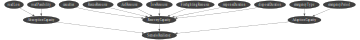

In [35]:
dot_structure = bn.toDot()
print(dot_structure)
gnb.showBN(bn)

In [36]:
def calculate_DiscreteVariable_Prior(node_name,data):
    category_counts = data.value_counts()
    # 计算总样本数
    total_samples = category_counts.sum()

    # 计算每个类别的概率分布
    category_probabilities = category_counts / total_samples
#     print(category_probabilities.tolist())
    bn.cpt(node_name).fillWith(category_probabilities.tolist())

In [59]:
def calculate_ContinuousVariable_Thorm(data):
    # 计算均值和标准差
    mu, std = norm.fit(data)
    # 打印拟合的均值和标准差
#     print(f"Fitted Mean (μ): {mu:.2f}")
#     print(f"Fitted Standard Deviation (σ): {std:.2f}")
    
    lower_bound = np.percentile(data, 5)  # 5th percentile
    upper_bound = np.percentile(data, 95)  # 95th percentile
#     print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    # Calculate the z-scores for the truncation bounds
    a = (lower_bound - mu) / std  # Lower bound in terms of z-score
    b = (upper_bound - mu) / std  # Upper bound in terms of z-score

    # Create a truncated normal distribution with the calculated parameters
    truncated_normal = truncnorm(a, b, loc=mu, scale=std)
    return truncated_normal

def discretize_calculate_probabilities(x,truncated_normal):
    prob = truncated_normal.cdf(x)
#     print(f"P(X < {x}) for a truncated normal distribution is: {prob}")
    return(prob)
def draw_thorm(truncated_normal,data):
    mu, std = norm.fit(data)
    lower_bound = np.percentile(data, 5)  # 5th percentile
    upper_bound = np.percentile(data, 95)  # 95th percentile
    sampled_values = truncated_normal.rvs(size=1000)
    plt.figure(figsize=(10, 6))
    plt.hist(sampled_values, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

    # 绘制截断正态分布曲线
    x = np.linspace(lower_bound, upper_bound, 1000)
    p = truncated_normal.pdf(x)
    plt.plot(x, p, 'k', linewidth=2, label=f'Truncated Normal Fit (μ={mu:.2f}, σ={std:.2f})')

    # 添加标签和图例
    plt.title('Truncated Normal Distribution Fit')
    plt.xlabel('Continuous Variable')
    plt.ylabel('Density')
    plt.legend()

    # 显示图形
    plt.show()

In [38]:
data = pd.read_excel(r"C:\Users\Tsing_loong\Desktop\Work Section\推演代码合成\推演代码合成\prior prob test.xlsx")
df = pd.DataFrame(data)

# 4.设置根节点的先验概率
for node in bn.nodes():
    node_name = bn.variable(node).name()
#     print(node_name != "emergencyPeriod")
    if (len(bn.parents(node)) == 0):
        if node_name not in ["disposalDuration", "responseDuration"]:
#         print(node_name)
            calculate_DiscreteVariable_Prior(node_name,df[node_name])
        elif node_name in ["disposalDuration", "responseDuration"]:
            truncated_normal = calculate_ContinuousVariable_Thorm(df[node_name])
            prob_0_15 = discretize_calculate_probabilities(15,truncated_normal)
            prob_15_30 = discretize_calculate_probabilities(30,truncated_normal) - prob_0_15
            prob_30_60 = discretize_calculate_probabilities(60,truncated_normal) - discretize_calculate_probabilities(30,truncated_normal)
            prob_morethan_60 = 1 - discretize_calculate_probabilities(60,truncated_normal)
#             print(prob_0_15,prob_15_30,prob_30_60,prob_morethan_60)
            bn.cpt(node_name).fillWith([prob_0_15,prob_15_30,prob_30_60,prob_morethan_60])

In [39]:
bn.cpt("AbsorptionCapacity")

(pyAgrum.Potential<double>@0000017C386C7EB0) 
             ||  AbsorptionCapacit|
roadPa|roadLo||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |

In [40]:
bn.cpt('AdaptionCapacity')

(pyAgrum.Potential<double>@0000017C386C7EF0) 
             ||  AdaptionCapacity |
emerge|emerge||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
2     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |
2     |1     || 0.0000  | 0.0000  |
0     |2     || 0.0000  | 0.0000  |
1     |2     || 0.0000  | 0.0000  |
2     |2     || 0.0000  | 0.0000  |
0     |3     || 0.0000  | 0.0000  |
1     |3     || 0.0000  | 0.0000  |
2     |3     || 0.0000  | 0.0000  |

In [41]:
bn.cpt('RecoveryCapacity')

(pyAgrum.Potential<double>@0000017C386C8470) 
                                                ||  RecoveryCapacity |
casual|AidRes|TowRes|Firefi|Rescue|dispos|respon||0        |1        |
------|------|------|------|------|------|------||---------|---------|
0     |0     |0     |0     |0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |0     |0     |0     |0     |0     || 0.0000  | 0.0000  |
0     |1     |0     |0     |0     |0     |0     || 0.0000  | 0.0000  |
1     |1     |0     |0     |0     |0     |0     || 0.0000  | 0.0000  |
0     |0     |1     |0     |0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |1     |0     |0     |0     |0     || 0.0000  | 0.0000  |
[...500 more line(s) ...]
0     |1     |0     |1     |1     |3     |3     || 0.0000  | 0.0000  |
1     |1     |0     |1     |1     |3     |3     || 0.0000  | 0.0000  |
0     |0     |1     |1     |1     |3     |3     || 0.0000  | 0.0000  |
1     |0     |1     |1     |1     |3     |3     || 0.0000  | 0.0000  |
0     |1     |1     |1     |1     |3     |3     || 0.0000  | 0.0000  |
1     |1     |1     |1     |1     |3     |3     || 0.0000  | 0.0000  |

In [42]:
# 定义评估结果与模糊数的映射关系
mapping_evaluation_fuzzy = {
    'VL': (0.0, 0.0, 0.1, 0.2),
    'L': (0.1, 0.2, 0.2, 0.3),
    'M': (0.2, 0.3, 0.4, 0.5),
    'H': (0.5, 0.6, 0.7, 0.8),
    'VH': (0.8, 0.9, 1.0, 1.0)
}

In [43]:
df = pd.read_excel(r"C:\Users\Tsing_loong\Desktop\Work Section\推演代码合成\推演代码合成\expert estimation test.xlsx")
print(df)

                    Node  Condition  State  E1  E2  E3  E4  E5  E6  E7
0     AbsorptionCapacity     [0, 0]      0   H   M   M   H  VH   L  VH
1     AbsorptionCapacity     [0, 0]      1   M   L  VL   M  VL   M   M
2     AbsorptionCapacity     [0, 1]      0  VH   L   L  VH   H  VH   L
3     AbsorptionCapacity     [0, 1]      1  VL   H   L  VL   M   L   L
4     AbsorptionCapacity     [1, 0]      0   H  VL   L   H  VH  VH   M
...                  ...        ...    ...  ..  ..  ..  ..  ..  ..  ..
1067  ScenarioResilience  [1, 0, 1]      1   H  VL   H   M  VL   H  VL
1068  ScenarioResilience  [1, 1, 0]      0   L   H  VH   H   H   H   H
1069  ScenarioResilience  [1, 1, 0]      1  VH  VL  VL   M   M   H   L
1070  ScenarioResilience  [1, 1, 1]      0   H   M  VL   H   H   L   H
1071  ScenarioResilience  [1, 1, 1]      1  VL  VH  VL   M  VH  VL   M

[1072 rows x 10 columns]


In [44]:
def calculate_fuzzy(row):
    fuzzy_numbers = [mapping_evaluation_fuzzy[r] for r in row]
    return fuzzy_numbers

In [45]:
df['fuzzy'] = df.iloc[:, -7:].apply(calculate_fuzzy, axis=1)
df['Condition'] = df['Condition'].tolist()
print(df)

                    Node  Condition  State  E1  E2  E3  E4  E5  E6  E7  \
0     AbsorptionCapacity     [0, 0]      0   H   M   M   H  VH   L  VH   
1     AbsorptionCapacity     [0, 0]      1   M   L  VL   M  VL   M   M   
2     AbsorptionCapacity     [0, 1]      0  VH   L   L  VH   H  VH   L   
3     AbsorptionCapacity     [0, 1]      1  VL   H   L  VL   M   L   L   
4     AbsorptionCapacity     [1, 0]      0   H  VL   L   H  VH  VH   M   
...                  ...        ...    ...  ..  ..  ..  ..  ..  ..  ..   
1067  ScenarioResilience  [1, 0, 1]      1   H  VL   H   M  VL   H  VL   
1068  ScenarioResilience  [1, 1, 0]      0   L   H  VH   H   H   H   H   
1069  ScenarioResilience  [1, 1, 0]      1  VH  VL  VL   M   M   H   L   
1070  ScenarioResilience  [1, 1, 1]      0   H   M  VL   H   H   L   H   
1071  ScenarioResilience  [1, 1, 1]      1  VL  VH  VL   M  VH  VL   M   

                                                  fuzzy  
0     [(0.5, 0.6, 0.7, 0.8), (0.2, 0.3, 0.4, 0.5), (.

In [46]:
def calculate_similarity(row):
    # 初始化结果列表，用于存储每个元素与其他元素差值的平均值
    ss = []
    avg_similarity = []
    relative_similarity = []
    # 获取数组的长度
    n = len(row)
    k = list(range(n))
    
    # 遍历数组中的每个元素（元组）
    for i in range(n):
        temp = []
        k_filtered = [element for element in k if element != i]
        for j in k_filtered:
            differences_sum = 1-(sum(abs(a - b) for a, b in zip(row[i], row[j])))/len(row[i])
            temp.append(differences_sum)
        avg_similarity.append(sum(temp)/len(temp))
        ss.append(temp)
        relative_similarity.append(avg_similarity[i]/sum(avg_similarity))
#     print(avg_similarity)
#     print(relative_similarity)
    
    return ss,avg_similarity,relative_similarity

In [47]:
df_expert = pd.read_excel(r"C:\Users\Tsing_loong\Desktop\Work Section\推演代码合成\推演代码合成\expertInfo.xlsx")
scores = df_expert.iloc[:, 1:].sum(axis=1)
total_score = scores.sum()
weight_list = list(scores / total_score)
print(weight_list)

[0.10619469026548672, 0.13274336283185842, 0.1415929203539823, 0.168141592920354, 0.1504424778761062, 0.13274336283185842, 0.168141592920354]


In [48]:
def calculate_aggrated_fuzzy(row):
    b = 0.5
    aggrated_fuzzy = [0.0, 0.0, 0.0, 0.0]  # 四个位置对应四个加权平均数
    global weight_list

    ss,avg_s,rela_s = calculate_similarity(row)
    cc = [(b * weight_list[i] + (1-b) * rela_s[i]) for i in range(len(rela_s))]
    weight = [i / sum(cc) for i in cc]#归一化，使和为1
    
    # 计算加权平均数
    for weights, tup in zip(weight, row):
#         print(weights)
        for i in range(len(tup)):
#             print('i:',tup[i])
#             print(tup[i] * weights)
            aggrated_fuzzy[i] += tup[i] * weights
    
    a1,a2,a3,a4 = aggrated_fuzzy
    defuzzified_possibility = ((a4+a3)**2 - a4*a3 - (a1+a2)**2 + a1*a2)/(3*(a4+a3-a2-a1))

    return defuzzified_possibility

In [49]:
#条件概率填充到 df
conditonProbability = []
for row in df['fuzzy']:
    conditonProbability.append(calculate_aggrated_fuzzy(row))
#    print(calculate_aggrated_fuzzy(row))
df['conditonProbability'] = conditonProbability

#条件概率归一化
def normalize(group):
    s = group['conditonProbability'].sum()
    group['conditonProbability'] = group['conditonProbability']/s
    return group

normalized_prob = (df.groupby(['Node', 'Condition']).apply(normalize))['conditonProbability']
df['conditonProbability'] = normalized_prob.tolist()
print(df)

                    Node  Condition  State  E1  E2  E3  E4  E5  E6  E7  \
0     AbsorptionCapacity     [0, 0]      0   H   M   M   H  VH   L  VH   
1     AbsorptionCapacity     [0, 0]      1   M   L  VL   M  VL   M   M   
2     AbsorptionCapacity     [0, 1]      0  VH   L   L  VH   H  VH   L   
3     AbsorptionCapacity     [0, 1]      1  VL   H   L  VL   M   L   L   
4     AbsorptionCapacity     [1, 0]      0   H  VL   L   H  VH  VH   M   
...                  ...        ...    ...  ..  ..  ..  ..  ..  ..  ..   
1067  ScenarioResilience  [1, 0, 1]      1   H  VL   H   M  VL   H  VL   
1068  ScenarioResilience  [1, 1, 0]      0   L   H  VH   H   H   H   H   
1069  ScenarioResilience  [1, 1, 0]      1  VH  VL  VL   M   M   H   L   
1070  ScenarioResilience  [1, 1, 1]      0   H   M  VL   H   H   L   H   
1071  ScenarioResilience  [1, 1, 1]      1  VL  VH  VL   M  VH  VL   M   

                                                  fuzzy  conditonProbability  
0     [(0.5, 0.6, 0.7, 0.8), (0.

C:\Users\Tsing_loong\AppData\Local\Temp\ipykernel_19756\2319494224.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_prob = (df.groupby(['Node', 'Condition']).apply(normalize))['conditonProbability']


In [50]:
# 将 Condition 和 State 结合为 cpt 填充时的索引列表
index = []
for i, row in df.iterrows():
    sublist = ast.literal_eval(row['Condition'])
    sublist.append(row['State'])
    index.append(sublist)
#print(index)

#创建 Potential 对象字典
cpt = {'AbsorptionCapacity': bn.cpt('AbsorptionCapacity'), 'AdaptionCapacity': bn.cpt('AdaptionCapacity'), 
       'RecoveryCapacity': bn.cpt('RecoveryCapacity'), 'ScenarioResilience': bn.cpt('ScenarioResilience')}
# 条件概率填充
for i, row in df.iterrows():
    (cpt[row['Node']])[ast.literal_eval(','.join(str(x) for x in index[i]))] = row['conditonProbability']
# 将 Potential 队形赋值给 cpt
for i in ['AbsorptionCapacity', 'AdaptionCapacity', 'RecoveryCapacity', 'ScenarioResilience']:
    bn.cpt(i).fillWith(cpt[i])
bn.cpt("AbsorptionCapacity")

(pyAgrum.Potential<double>@0000017C386C7EB0) 
             ||  AbsorptionCapacit|
roadPa|roadLo||0        |1        |
------|------||---------|---------|
0     |0     || 0.6840  | 0.3160  |
1     |0     || 0.7272  | 0.2728  |
0     |1     || 0.5971  | 0.4029  |
1     |1     || 0.5979  | 0.4021  |

In [51]:
bn.cpt("AdaptionCapacity")

(pyAgrum.Potential<double>@0000017C386C7EF0) 
             ||  AdaptionCapacity |
emerge|emerge||0        |1        |
------|------||---------|---------|
0     |0     || 0.6445  | 0.3555  |
1     |0     || 0.5674  | 0.4326  |
2     |0     || 0.4275  | 0.5725  |
0     |1     || 0.6242  | 0.3758  |
1     |1     || 0.5585  | 0.4415  |
2     |1     || 0.6080  | 0.3920  |
0     |2     || 0.6659  | 0.3341  |
1     |2     || 0.4163  | 0.5837  |
2     |2     || 0.5674  | 0.4326  |
0     |3     || 0.6756  | 0.3244  |
1     |3     || 0.7826  | 0.2174  |
2     |3     || 0.6640  | 0.3360  |

In [52]:
bn.cpt("RecoveryCapacity")

(pyAgrum.Potential<double>@0000017C386C8470) 
                                                ||  RecoveryCapacity |
casual|AidRes|TowRes|Firefi|Rescue|dispos|respon||0        |1        |
------|------|------|------|------|------|------||---------|---------|
0     |0     |0     |0     |0     |0     |0     || 0.7363  | 0.2637  |
1     |0     |0     |0     |0     |0     |0     || 0.3699  | 0.6301  |
0     |1     |0     |0     |0     |0     |0     || 0.6399  | 0.3601  |
1     |1     |0     |0     |0     |0     |0     || 0.7062  | 0.2938  |
0     |0     |1     |0     |0     |0     |0     || 0.8246  | 0.1754  |
1     |0     |1     |0     |0     |0     |0     || 0.3178  | 0.6822  |
[...500 more line(s) ...]
0     |1     |0     |1     |1     |3     |3     || 0.5238  | 0.4762  |
1     |1     |0     |1     |1     |3     |3     || 0.4190  | 0.5810  |
0     |0     |1     |1     |1     |3     |3     || 0.7187  | 0.2813  |
1     |0     |1     |1     |1     |3     |3     || 0.7141  | 0.2859  |
0     |1     |1     |1     |1     |3     |3     || 0.7411  | 0.2589  |
1     |1     |1     |1     |1     |3     |3     || 0.5802  | 0.4198  |

In [53]:
bn.cpt("ScenarioResilience")

(pyAgrum.Potential<double>@0000017C386C74D0) 
                    ||  ScenarioResilienc|
Adapti|Absorp|Recove||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.5735  | 0.4265  |
1     |0     |0     || 0.6993  | 0.3007  |
0     |1     |0     || 0.6415  | 0.3585  |
1     |1     |0     || 0.6592  | 0.3408  |
0     |0     |1     || 0.6434  | 0.3566  |
1     |0     |1     || 0.5796  | 0.4204  |
0     |1     |1     || 0.5621  | 0.4379  |
1     |1     |1     || 0.6001  | 0.3999  |

In [54]:
# 6.证据更新
#onto = get_ontology("file://ScenarioOntology.owl")
#onto.load()
# print(list(onto.data_properties()))
# print(list(onto.properties()))
#with onto:
#    rule1 = Imp()
#     rule1.set_as_rule("""""")
# 当保存预案时，更新预案实例
# 执行swrl推理
#sync_reasoner_pellet(infer_property_values = True, infer_data_property_values = True)

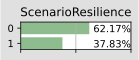

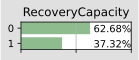

In [55]:
# 7.执行推理：使用lazyPropagation推理引擎精确推断
ie=gum.LazyPropagation(bn)
# 没有新数据的推断
ie.makeInference()
gnb.showProba(ie.posterior("ScenarioResilience"))
gnb.showProba(ie.posterior("RecoveryCapacity"))

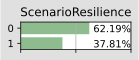

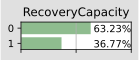

In [56]:
# 有新数据的推断
ie.setEvidence({'AidResource': 0})
ie.makeInference()
gnb.showProba(ie.posterior("ScenarioResilience"))
gnb.showProba(ie.posterior("RecoveryCapacity"))

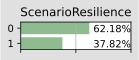

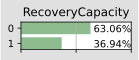

In [57]:
# 有新数据的推断
ie.setEvidence({'disposalDuration': 2})
ie.makeInference()
gnb.showProba(ie.posterior("ScenarioResilience"))
gnb.showProba(ie.posterior("RecoveryCapacity"))

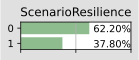

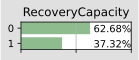

In [58]:
# 有新数据的推断
ie.setEvidence({'AbsorptionCapacity': 1})
ie.makeInference()
gnb.showProba(ie.posterior("ScenarioResilience"))
gnb.showProba(ie.posterior("RecoveryCapacity"))